# Advanced Lane Lines - Heat map

In this notebook the following points from the Project 5 Vehicle Detection are implemented:
*  create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Step 0: Import required libraries

In [1]:
from IPython.core.display import display, HTML
from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import pickle
import cv2
import glob
import time
import os

from feature_extraction import extractFeatures, configParams, extract_hog_features, extract_color_features
from sliding_window import findCars, slide_window, search_windows, draw_boxes

## Step 1:  Udacity helper functions to detect cars in an image by sliding window

In [2]:
def add_heat(heatmap, bbox_list):

    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_heat_threshold_one_image(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    return heatmap

def apply_heat_threshold(heatmap, hot_windows):
    heatmap[heatmap <= 1 + len(hot_windows)//2] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):

        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    return img

def get_heat_based_bboxes(img, hot_windows, verbose=False):
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    # heat = apply_heat_threshold(heat, configParams['heat_threshold'])
    heat = apply_heat_threshold(heat, hot_windows)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    if verbose is True:
        print("sliding_windows::get_heat_based_bboxes(): no.of labels: {}".format(1+labels[1]))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

def get_heat_based_bboxes_one_image(img, hot_windows, verbose=False):
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_heat_threshold_one_image(heat, configParams['heat_threshold'])

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    if verbose is True:
        print("sliding_windows::get_heat_based_bboxes(): no.of labels: {}".format(1+labels[1]))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

## Step 2: Test heatmap on sliding window test images 

In [3]:
def testHeatMapOnSlidingSearchWindowImages():    
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    svc, X_scaler = pickle.load( open("./classifier_pickle.p", "rb" ) )
    
    for filename_img in filenames_img:
        
        # Read image
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)
        
        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        
        y_start_stop = [np.int(image.shape[0]/2), image.shape[0] - 60]        
        hot_windows = []
        all_windows = []
        # HOG features extracted on every search window separately
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))

        hot_windows = search_windows(image, windows, svc, X_scaler)                                   

        print("\n# hot-windows: {}".format(len(hot_windows)))
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
        draw_img, heatmap = get_heat_based_bboxes_one_image(draw_image, hot_windows, verbose=True)
        print("heatmap: {} to {}".format(np.min(heatmap), np.max(heatmap)))
        
        fig = plt.figure(count_fig, figsize=(8, 8), dpi=100)
        plt.subplot(131)
        plt.imshow(window_img)
        plt.title('Hot windows in test image') 
        plt.subplot(132)
        plt.imshow(draw_img)
        plt.title('Car Positions in test image')
        plt.subplot(133)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map in test image')
        fig.tight_layout()
        count_fig += 1
    
    plt.show() 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



# hot-windows: 5
sliding_windows::get_heat_based_bboxes(): no.of labels: 2
heatmap: 0.0 to 2.0

# hot-windows: 5
sliding_windows::get_heat_based_bboxes(): no.of labels: 2
heatmap: 0.0 to 3.0

# hot-windows: 5
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 2.0

# hot-windows: 0
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0

# hot-windows: 2
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0

# hot-windows: 0
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0


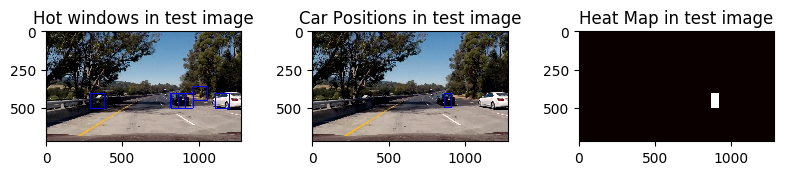

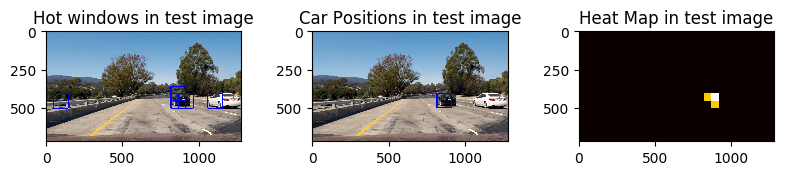

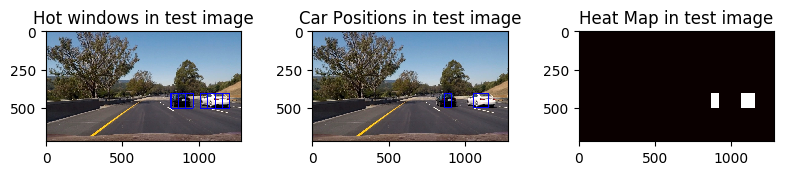

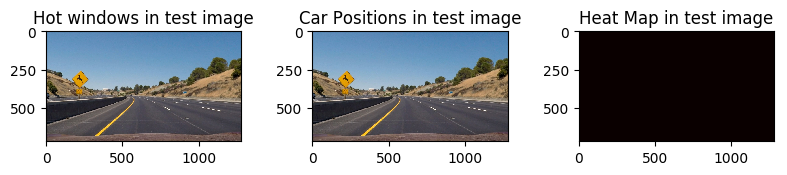

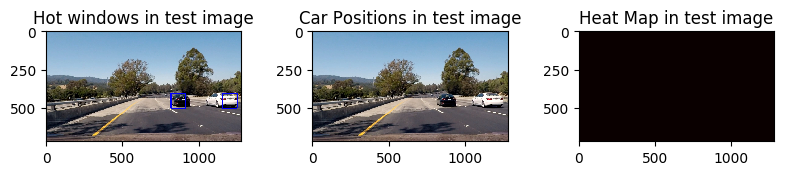

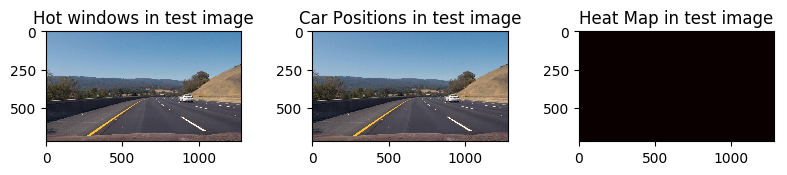

In [4]:
testHeatMapOnSlidingSearchWindowImages()

## Step 4: Test heatmap on HOG subsampling test images

In [5]:
def testHeatMapOnHOGSubsamplingSearchImages():    
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    svc, X_scaler = pickle.load( open("./classifier_pickle.p", "rb" ) )
    
    for filename_img in filenames_img:
        
        # Read image
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)
        
        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        
        y_start_stop=[350, 656] 

        hot_windows = []
        all_windows = []
        windows, car_windows = findCars(image, y_start_stop, svc, X_scaler, scale=1.5)
        hot_windows += car_windows
        all_windows += windows
                                  

        print("\n# hot-windows: {}".format(len(hot_windows)))
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
        draw_img, heatmap = get_heat_based_bboxes_one_image(draw_image, hot_windows, verbose=True)
        print("heatmap: {} to {}".format(np.min(heatmap), np.max(heatmap)))
        
        fig = plt.figure(count_fig, figsize=(8, 8), dpi=100)
        plt.subplot(131)
        plt.imshow(window_img)
        plt.title('Hot windows in test image') 
        plt.subplot(132)
        plt.imshow(draw_img)
        plt.title('Car Positions in test image')
        plt.subplot(133)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map in test image')
        fig.tight_layout()
        count_fig += 1
  
    plt.show() 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



# hot-windows: 14
sliding_windows::get_heat_based_bboxes(): no.of labels: 4
heatmap: 0.0 to 8.0

# hot-windows: 12
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 7.0

# hot-windows: 14
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 6.0

# hot-windows: 0
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0

# hot-windows: 12
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 5.0

# hot-windows: 2
sliding_windows::get_heat_based_bboxes(): no.of labels: 2
heatmap: 0.0 to 2.0


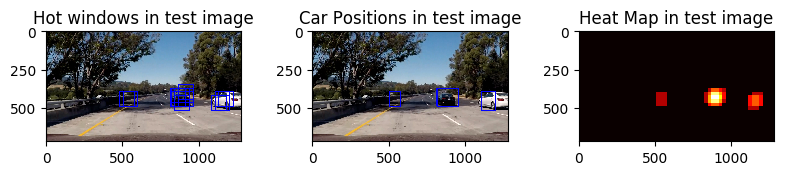

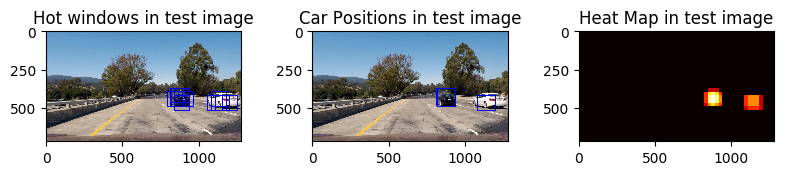

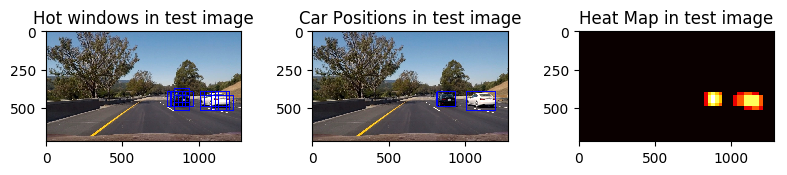

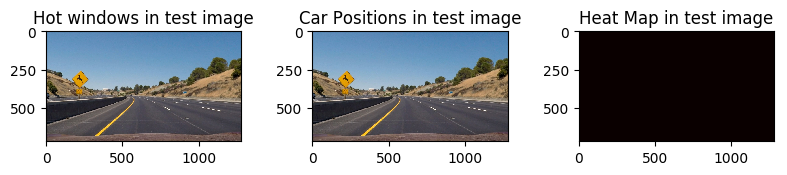

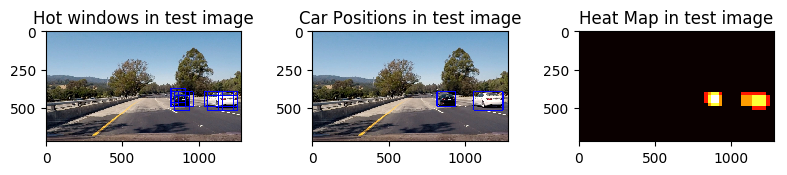

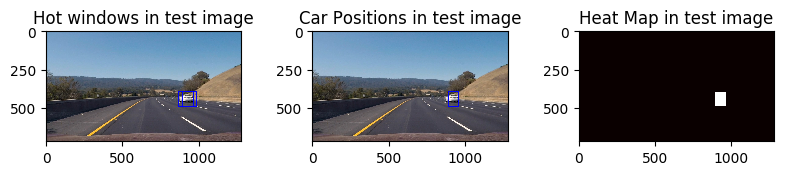

In [6]:
testHeatMapOnHOGSubsamplingSearchImages() 